In [1]:
import pandas as pd
import neurokit2 as nk
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os
import wfdb
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import h5py
from datetime import datetime, timedelta
from utils.ecg_windowing import make_baseline_windows, window_vtac_records
from utils.ecg_features import process_dataframe, create_windowed_ecg_from_mat , convert_and_relabel_windowed_df_full
from utils.ecg_plots import compute_refs_and_zscores, plot_subject_panels 

In [2]:
# --- Define constants ---
SAMPLE_RATE = 250  # Samples per second

# --- Directory containing the records ---
record_dir = 'cu-ventricular-tachyarrhythmia-database-1.0.0'

# --- List all records in the directory ---
record_files = [f for f in os.listdir(record_dir) if f.endswith('.dat')]
record_names = [os.path.splitext(f)[0] for f in record_files]

# Inspect first record's header to see lead info
lead_info = {}
for rec in record_names:
    try:
        record = wfdb.rdrecord(os.path.join(record_dir, rec))
        lead_info[rec] = record.sig_name
    except Exception as e:
        lead_info[rec] = f"Error reading: {e}"

lead_info


{'cu23': ['ECG'],
 'cu22': ['ECG'],
 'cu08': ['ECG'],
 'cu34': ['ECG'],
 'cu20': ['ECG'],
 'cu21': ['ECG'],
 'cu35': ['ECG'],
 'cu09': ['ECG'],
 'cu31': ['ECG'],
 'cu25': ['ECG'],
 'cu19': ['ECG'],
 'cu18': ['ECG'],
 'cu24': ['ECG'],
 'cu30': ['ECG'],
 'cu26': ['ECG'],
 'cu32': ['ECG'],
 'cu33': ['ECG'],
 'cu27': ['ECG'],
 'cu02': ['ECG'],
 'cu16': ['ECG'],
 'cu17': ['ECG'],
 'cu03': ['ECG'],
 'cu29': ['ECG'],
 'cu15': ['ECG'],
 'cu01': ['ECG'],
 'cu14': ['ECG'],
 'cu28': ['ECG'],
 'cu10': ['ECG'],
 'cu04': ['ECG'],
 'cu05': ['ECG'],
 'cu11': ['ECG'],
 'cu07': ['ECG'],
 'cu13': ['ECG'],
 'cu12': ['ECG'],
 'cu06': ['ECG']}

In [3]:
# Override (e.g., 200 Hz, 20s window, 2s shift)
windowed_df = window_vtac_records(
    "cu-ventricular-tachyarrhythmia-database-1.0.0",
    sample_rate=250,
    win_sec=30,
    shift_sec=5,
)

In [4]:
windowed_df 

Record   Start     End     Label  \
0      cu23       0    7500  Pre-VTAC   
1      cu23    1250    8750  Pre-VTAC   
2      cu23    2500   10000  Pre-VTAC   
3      cu23    3750   11250  Pre-VTAC   
4      cu23    5000   12500  Pre-VTAC   
...     ...     ...     ...       ...   
3355   cu06  113750  121250     Other   
3356   cu06  115000  122500     Other   
3357   cu06  116250  123750     Other   
3358   cu06  117500  125000     Other   
3359   cu06  118750  126250     Other   

                                                    ECG  
0     [-0.215, -0.2, -0.18, -0.18, -0.195, -0.195, -...  
1     [-0.18, -0.205, -0.2, -0.19, -0.195, -0.21, -0...  
2     [-0.235, -0.245, -0.235, -0.245, -0.24, -0.25,...  
3     [0.715, 0.205, -0.1, -0.21, -0.205, -0.22, -0....  
4     [0.065, -0.04, -0.08, -0.07, 0.06, 0.27, 0.58,...  
...                                                 ...  
3355  [0.455, 0.4625, 0.4725, 0.46, 0.4425, 0.4175, ...  
3356  [-0.43, -0.44, -0.4425, -0.455, -0.4475, -0.42...  
3357  [-0.2875, -0.2975, -0.3, -0.305, -0.2975, -0.2...  
3358  [-0.175, -0.175, -0.17, -0.1575, -0.15, -0.147...  
3359  [0.0275, 0.0275, 0.0375, 0.04, 0.04, 0.0275, 0...  

[3360 rows x 5 columns]

In [5]:
windowed_df ["Label"].unique()

array(['Pre-VTAC', 'VTAC', 'Other'], dtype=object)

In [6]:
windowed_df["Label"].unique()

array(['Pre-VTAC', 'VTAC', 'Other'], dtype=object)

|------Other------|-------Pre-VTAC-------|===VTAC===|---------Other---------|
                                               ↑
                                        VTAC Event Starts


In [7]:
alarms_df = pd.read_csv("VTSampleData/alarms.csv")
alarms_df

StudyID    Files      StartTime          Alarm  Duration
0    S0015  FID0001  9/21/24 19:55         V TACH        28
1    S0016  FID0002   9/22/24 6:29         V TACH        41
2    S0018  FID0003  9/25/24 22:30         V TACH        26
3    S0004  FID0004  9/18/24 11:28         V TACH        50
4    S0005  FID0004  9/18/24 11:29         V TACH       103
5    S0006  FID0004  9/18/24 16:34         V TACH        59
6    S0007  FID0004  9/18/24 16:38         V TACH        42
7    S0008  FID0004  9/18/24 16:39         V TACH        27
8    S0009  FID0004  9/18/24 16:40         V TACH        59
9    S0010  FID0004  9/18/24 16:43         V TACH        22
10   S0011  FID0004  9/18/24 16:44         V TACH        60
11   S0017  FID0005  6/27/24 20:30         V TACH        26
12   S0022  FID0006   7/8/24 21:20         V TACH        63
13   S0025  FID0007  7/29/24 17:14         V TACH        24
14   S0014  FID0008  10/13/24 6:48         V TACH        20
15   S0001  FID0009   7/2/24 22:24         V TACH        70
16   S0012  FID0010   7/5/24 16:50         V TACH        37
17   S0013  FID0010   7/5/24 20:11         V TACH        82
18   S0019  FID0011   10/4/24 2:49         V TACH        37
19   S0020  FID0012  10/4/24 16:39  V FIB/ V TACH        28
20   S0021  FID0012  10/4/24 17:26         V TACH        26
21   S0002  FID0013   8/6/24 15:39  V FIB/ V TACH        23
22   S0003  FID0014   7/26/24 1:14         V TACH        35
23   S0023  FID0015   10/9/24 7:40         V TACH        70
24   S0024  FID0015   10/9/24 7:41         V TACH        52
25   S0026  FID0016   8/2/24 17:12         V TACH         8
26   S0027  FID0016   8/2/24 17:14         V TACH        17
27   S0028  FID0016   8/2/24 17:18         V TACH        19
28   S0029  FID0016   8/2/24 17:20         V TACH        21
29   S0030  FID0016   8/2/24 17:27         V TACH        16
30   S0031  FID0016   8/2/24 17:31         V TACH        35
31   S0032  FID0016   8/2/24 17:36         V TACH        27
32   S0033  FID0017  9/25/24 13:29         V TACH       115
33   S0034  FID0017  9/25/24 13:31         V TACH        26
34   S0035  FID0018   9/28/24 1:25         V TACH       138
35   S0036  FID0018   9/28/24 1:26      VFIB/VTAC         3
36   S0037  FID0018   9/28/24 1:26         V TACH        54
37   S0038  FID0019   10/4/24 9:02         V TACH       121
38   S0039  FID0020  10/4/24 22:28  V FIB/ V TACH        73
39   S0040  FID0021  11/27/24 8:14         V TACH        32

In [8]:
alarms_df = pd.read_csv("VTSampleData/alarms.csv")

# ----------------------------------
# Randomly choose 10 UNIQUE StudyIDs
# ----------------------------------
np.random.seed(42)  # reproducibility

selected_study_ids = (
    alarms_df["Files"]
    .drop_duplicates()
    .sample(n=10, random_state=42)
    .tolist()
)

# ----------------------------------
# Get corresponding Files (FIDs)
# ----------------------------------
target_files = (
    alarms_df.loc[alarms_df["Files"].isin(selected_study_ids), "Files"]
    .unique()
    .tolist()
)

print("\nTarget Files:")
print(target_files)


Target Files:
['FID0001', 'FID0002', 'FID0004', 'FID0006', 'FID0009', 'FID0012', 'FID0016', 'FID0017', 'FID0018', 'FID0019']


In [9]:
sampling_rate = 240

alarms_df = pd.read_csv("VTSampleData/alarms.csv")
all_windowed = []

# --- Generate windows for selected files only ---
for file in target_files:
    try:
        print(f"[INFO] Processing {file}")
        df = create_windowed_ecg_from_mat(
            alarms_df,
            file,
            sampling_rate=sampling_rate,
            waveform_dir="VTSampleData/waveform",
            window_duration=30,
            window_shift=5,
            pre_buffer_sec=3600,
            post_buffer_sec=500,
        )
        if df is not None and not df.empty:
            all_windowed.append(df)
    except Exception as e:
        print(f"[ERROR] Could not window {file}: {e}")
        continue

# --- CONCAT ALL WINDOWS INTO ONE MASTER DF ---
windowed_df_full = pd.concat(all_windowed, ignore_index=True)
print("Total windows created:", len(windowed_df_full))

[INFO] Processing FID0001
[INFO] Processing FID0002
[INFO] Processing FID0004
[INFO] Processing FID0006
[INFO] Processing FID0009
[INFO] Processing FID0012
[INFO] Processing FID0016
[INFO] Processing FID0017
[INFO] Processing FID0018
[INFO] Processing FID0019
Total windows created: 6816


In [10]:
# 1. Collect VTAC intervals
vtac_intervals = []
for _, row in alarms_df.iterrows():
    vs = pd.to_datetime(row["StartTime"], format="%m/%d/%y %H:%M")
    ve = vs + pd.Timedelta(seconds=row["Duration"])
    vtac_intervals.append((vs, ve))

# 2. Convert and relabel
windowed_df_final = convert_and_relabel_windowed_df_full(
    windowed_df_full,
    vtac_intervals,
    sampling_rate=240,
    win_sec=30,
    shift_sec=5
)

# 3. Check output
print(windowed_df_final.head())
print(windowed_df_final["Label"].value_counts())

    Record  Start    End     Label  \
0  FID0001      0   7200  Pre-VTAC   
1  FID0001   1200   8400  Pre-VTAC   
2  FID0001   2400   9600  Pre-VTAC   
3  FID0001   3600  10800  Pre-VTAC   
4  FID0001   4800  12000  Pre-VTAC   

                                                 ECG  
0  [-160, -160, -154, -152, -151, -149, -150, -15...  
1  [54, 54, 51, 46, 45, 40, 36, 40, 45, 46, 47, 4...  
2  [-46, -100, -112, -97, -95, -104, -98, -102, -...  
3  [56, 55, 56, 56, 52, 49, 47, 45, 47, 46, 44, 3...  
4  [-40, -48, -59, -67, -60, -46, -32, -29, -35, ...  
Label
Pre-VTAC    6653
VTAC         163
Name: count, dtype: int64


In [11]:
windowed_df_final["Label"].unique()

array(['Pre-VTAC', 'VTAC'], dtype=object)

In [12]:
windowed_df_final["ECG"].apply(len).mean()
mean_len = windowed_df_final["ECG"].apply(len).mean()
print("Mean ECG segment length:", mean_len)

Mean ECG segment length: 7200.0


In [13]:
# Run with sampling_rate=240
results_240 = process_dataframe(windowed_df_final, sampling_rate=240, extension_sec=30)


=== VTAC Ratio Change Per Subject ===
         VTAC_Ratio_Before(%)  VTAC_Ratio_After(%)  Delta(After-Before)
Record                                                                 
FID0001              0.000000             0.000000             0.000000
FID0002              6.611570            16.528926             9.917355
FID0004              6.935123             9.619687             2.684564
FID0006              1.761518             2.439024             0.677507
FID0009              1.846966             3.430079             1.583113
FID0012              0.732601             2.319902             1.587302
FID0016              1.226994             3.067485             1.840491
FID0017              3.460621             5.011933             1.551313
FID0018              3.202847             4.626335             1.423488
FID0019              2.979738             4.410012             1.430274


  0%|          | 0/6816 [00:00<?, ?it/s]

 28%|██▊       | 1905/6816 [03:01<00:03, 1258.28it/s]

[ERROR] '[7202] not in index'


 86%|████████▋ | 5887/6816 [12:18<01:25, 10.80it/s]  /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 86%|████████▋ | 5894/6816 [12:18<00:39, 23.50it/s]

[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer


100%|██████████| 6816/6816 [14:31<00:00,  7.82it/s]


In [14]:
results_240["Label"].unique()

array(['Pre-VTAC', 'VTAC'], dtype=object)

In [15]:
windowed_df["Label"].unique()

array(['Pre-VTAC', 'VTAC', 'Other'], dtype=object)

In [16]:
# Run with sampling_rate=250
results_250 = process_dataframe(windowed_df, sampling_rate=250, extension_sec=30)


=== VTAC Ratio Change Per Subject ===
        VTAC_Ratio_Before(%)  VTAC_Ratio_After(%)  Delta(After-Before)
Record                                                                
cu01               61.458333            61.458333             0.000000
cu02                0.000000             0.000000             0.000000
cu03                8.333333             8.333333             0.000000
cu04               72.916667            72.916667             0.000000
cu05               25.000000            31.250000             6.250000
cu06               37.500000            50.000000            12.500000
cu07               67.708333            67.708333             0.000000
cu08               16.666667            16.666667             0.000000
cu09               18.750000            31.250000            12.500000
cu10               39.583333            39.583333             0.000000
cu11               28.125000            28.125000             0.000000
cu12               46.875000          

 13%|█▎        | 431/3360 [00:42<04:22, 11.16it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_pe

[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer


 19%|█▊        | 623/3360 [00:55<03:54, 11.66it/s]

[ERROR] '[7505] not in index'


 37%|███▋      | 1229/3360 [01:53<03:23, 10.49it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 37%|███▋      | 1242/3360 [01:53<00:51, 40.91it/s]

[ERROR] cannot convert float NaN to integer


 37%|███▋      | 1254/3360 [01:55<02:36, 13.44it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 38%|███▊      | 1284/3360 [01:55<00:44, 46.76it/s]

[ERROR] cannot convert float NaN to integer


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 39%|███▉      | 1310/3360 [01:55<00:37, 54.11it/s]

[ERROR] cannot convert float NaN to integer


 48%|████▊     | 1625/3360 [02:26<02:54,  9.96it/s]

[ERROR] '[7505] not in index'


 68%|██████▊   | 2287/3360 [03:36<01:13, 14.62it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 68%|██████▊   | 2292/3360 [03:36<00:49, 21.76it/s]

[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer


 68%|██████▊   | 2295/3360 [03:36<00:54, 19.66it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 68%|██████▊   | 2298/3360 [03:37<00:48, 21.74it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 69%|██████▊   | 2306/3360 [03:37<00:30, 34.86it/s]

[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer


 71%|███████   | 2380/3360 [03:42<01:23, 11.74it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 71%|███████   | 2387/3360 [03:42<00:44, 21.70it/s]

[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer
[ERROR] cannot convert float NaN to integer


 74%|███████▍  | 2489/3360 [03:51<00:41, 20.94it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 74%|███████▍  | 2497/3360 [03:52<00:31, 27.15it/s]

[ERROR] cannot convert float NaN to integer


 79%|███████▉  | 2661/3360 [04:12<00:57, 12.23it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 79%|███████▉  | 2665/3360 [04:12<00:38, 18.02it/s]

[ERROR] cannot convert float NaN to integer


 80%|████████  | 2690/3360 [04:14<00:33, 20.19it/s]

[ERROR] '[7500] not in index'


 85%|████████▌ | 2859/3360 [04:30<00:40, 12.38it/s]

[ERROR] '[7500] not in index'


 85%|████████▌ | 2865/3360 [04:30<00:37, 13.37it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
 85%|████████▌ | 2868/3360 [04:31<00:32, 14.91it/s]

[ERROR] cannot convert float NaN to integer


100%|██████████| 3360/3360 [05:09<00:00, 10.84it/s] 


# Visualizations 

In [17]:
# 1) Compute refs, global metrics, baseline z-scores, VTAC_Label
zscores_df_250 = compute_refs_and_zscores(results_250, sampling_rate=250, window_len_sec=30)

[SKIP] Record cu02: No VTAC detected.
[SKIP] Record cu14: No VTAC detected.
[SKIP] Record cu21: No usable pre-VTAC baseline.
[SKIP] Record cu30: No usable pre-VTAC baseline.


In [18]:
# 2) Compute refs, global metrics, baseline z-scores, VTAC_Label
zscores_df_240 = compute_refs_and_zscores(results_240, sampling_rate=240, window_len_sec=30)

[SKIP] Record FID0001: No VTAC detected.


In [19]:
# Concatenate both dataframes
zscores_df = pd.concat(
    [zscores_df_250, zscores_df_240],
    ignore_index=True
)

print("Final combined shape:", zscores_df.shape)

Final combined shape: (8471, 57)


Plotting subjects: ['cu04' 'FID0003' 'FID0004' 'FID0005' 'FID0011' 'FID0012' 'FID0015']


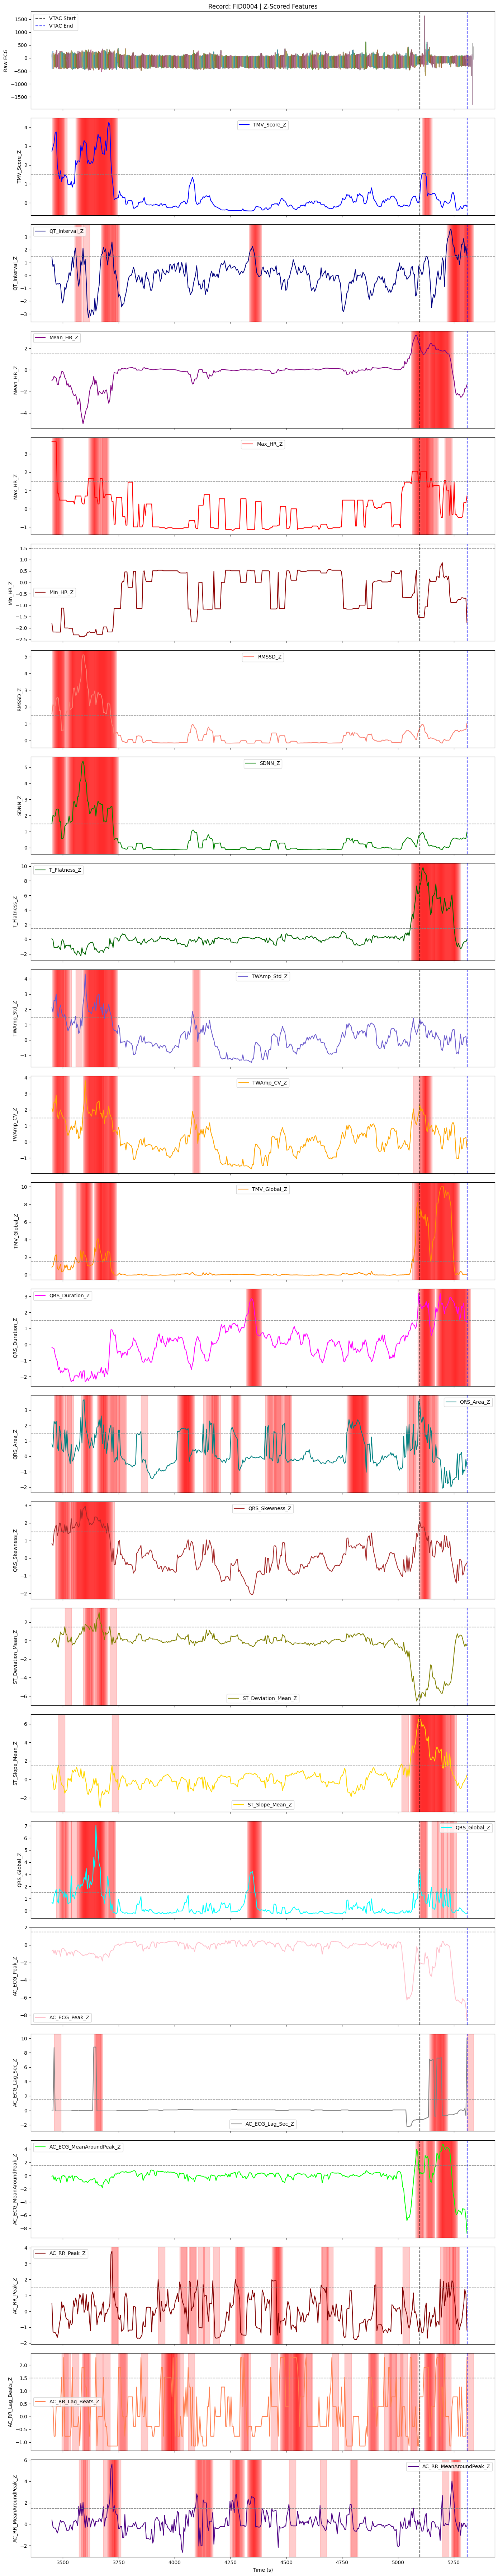

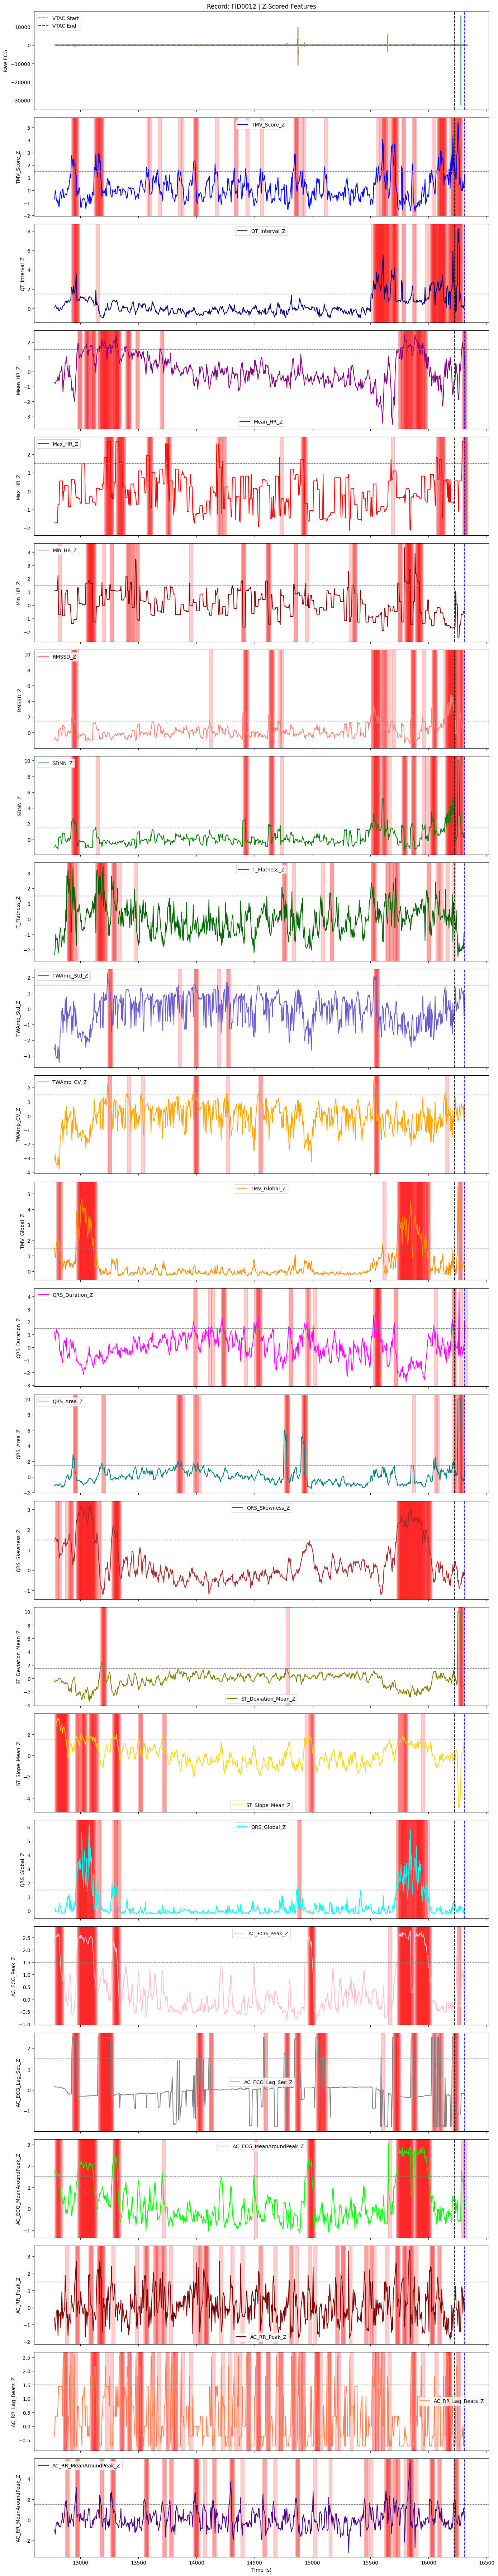

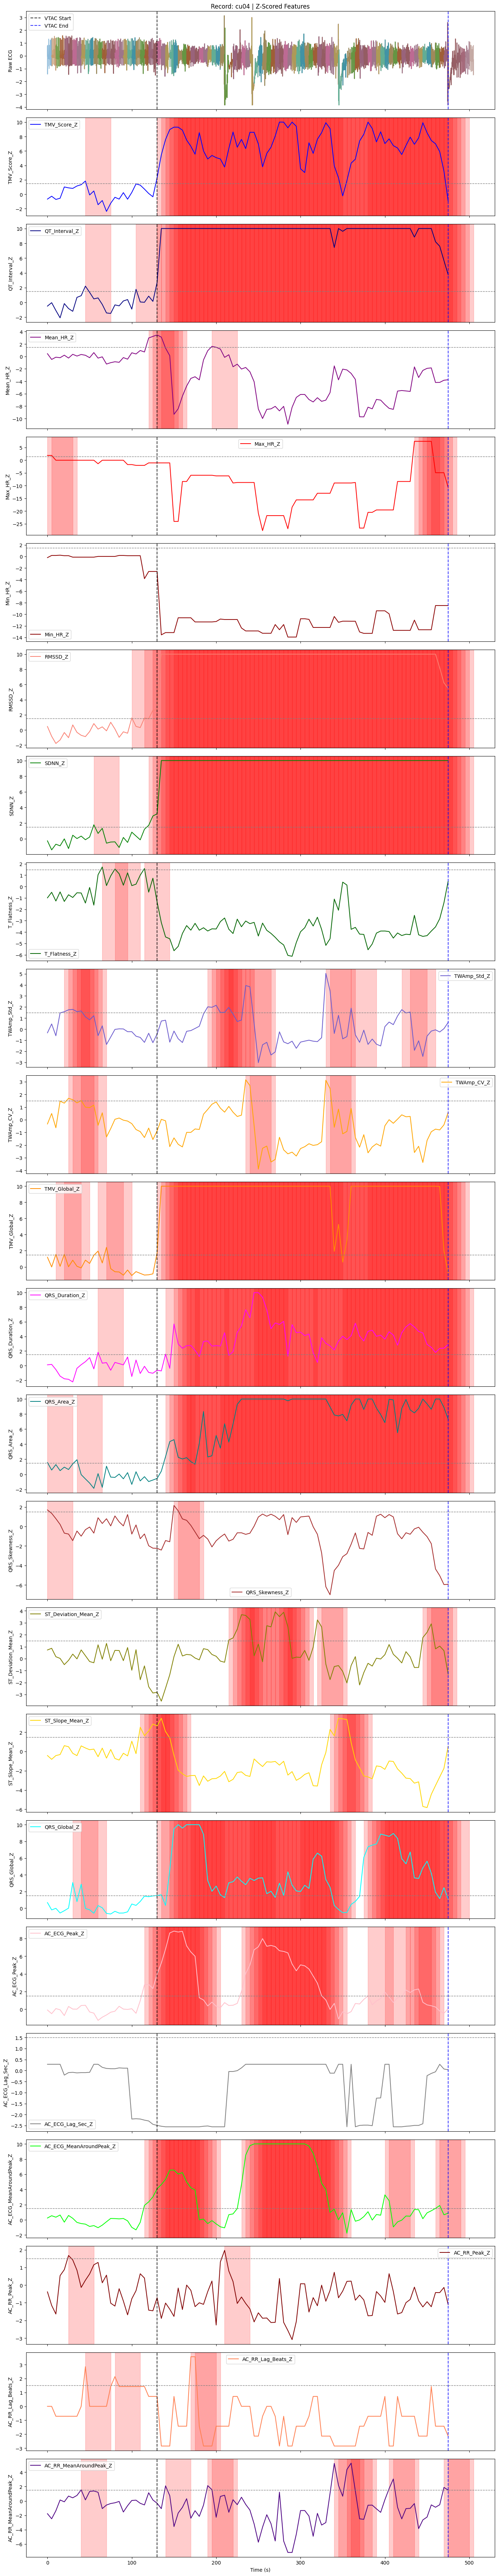

In [20]:
rng = np.random.default_rng(42)
unique_records = zscores_df['Record'].dropna().astype(str).unique()

k = min(2, len(unique_records))

# Ensure at least one starts with 'cu'
cu_candidates = [r for r in unique_records if r.startswith('cu')]
picked = []

if cu_candidates:
    picked.append(rng.choice(cu_candidates, size=1, replace=False)[0])


picked = np.concatenate([picked, np.array(["FID0003", 'FID0004', "FID0005","FID0011","FID0012","FID0015"])])
# Fill the rest from remaining pool (excluding what we already picked)
remaining_pool = [r for r in unique_records if r not in picked]
if remaining_pool and k - len(picked) > 0:
    picked.extend(rng.choice(remaining_pool, size=min(k - len(picked), len(remaining_pool)), replace=False))

picked = np.array(picked)
print("Plotting subjects:", picked)

subset = zscores_df[zscores_df['Record'].isin(picked)].copy()
plot_subject_panels(subset, sampling_rate=250, window_len_sec=30)

# Saving the features

In [21]:
os.makedirs("data/processed", exist_ok=True)
zscores_df.to_pickle("data/processed/zscores_df.pkl")